# About this Notebook

The goal of this notebook is to build a classifier to find toxic comments. The data has been taken from a series of Kaggle competitions to classify Wikipedia comments as toxic/nontoxic. The data has been sourced from Google and Jigsaw. 

The notebook will start with simple bag-of-words and tf-idf features and use simple models like logistic regression and Naive Bayes to perform classification with these features. Though the full dataset includes non-English comments, I will restrict myself to English-only comment for this iteration. 

We will then move on to deep learning approaches, using a combination of pretrained word embeddings and simple deep learning models like RNNs and 1D convolutions to do more benchmarking. 

Next, we will explore deep learning models that have 'memory' using LSTMs (Long Short Term Memory) and GRUs (Gated Recurrent Units). 

Finally, we will approach state of the art performance using pretrained models like BERT and xlnet.

For metrics, I will focus more on recall than precision as I believe finding all toxic comments is more important that mislabelling some nontoxic comments. In addition to recall, I will look at the confusion matrix and precision-recall curves. 

Credits:
https://www.kaggle.com/tanulsingh077/deep-learning-for-nlp-zero-to-transformers-bert

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

## Load data

In [2]:
train = pd.read_csv('jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv')
#The following is a non-English dataset and won't be used presently
validation = pd.read_csv('jigsaw-multilingual-toxic-comment-classification/validation.csv')
#The following is a non-English dataset and won't be used presently
test = pd.read_csv('jigsaw-multilingual-toxic-comment-classification/test.csv')

## EDA

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 8 columns):
id               223549 non-null object
comment_text     223549 non-null object
toxic            223549 non-null int64
severe_toxic     223549 non-null int64
obscene          223549 non-null int64
threat           223549 non-null int64
insult           223549 non-null int64
identity_hate    223549 non-null int64
dtypes: int64(6), object(2)
memory usage: 13.6+ MB


We will drop the other columns and approach this problem as a Binary Classification Problem and also we will have our exercise done on a smaller subsection of the dataset(only 12000 data points) to make it easier to train the models

In [5]:
train.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)

## Sample data

In [6]:
train = train.loc[:10000,:]
train.comment_text[train.toxic==1][1:2].values

array(['Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'],
      dtype=object)

## Explore Traditional Text Preprocessing Techniques

In [7]:
#Explore regex cleanups, # of unknown words, and lemmatization

## Create train and test sets

In [8]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.comment_text.values, train.toxic.values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)


## Create Features

In [9]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(xtrain)
count_valid = count_vectorizer.transform(xvalid)


## Define Metrics

In [64]:
def run_metrics(predictions, predictions_prob, target, visualize=True):
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions_prob)
    roc_auc = metrics.auc(fpr, tpr)
    precision, recall, thresholds = metrics.precision_recall_curve(target, predictions_prob)
    average_precision = metrics.average_precision_score(yvalid, pred)
    #average_recall = metrics.recall_score(yvalid, pred)
    print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
    accuracy = metrics.accuracy_score(yvalid, pred)
    print(metrics.confusion_matrix(yvalid, pred, labels=[0,1]))
    print("Accuracy Score: {0:0.2f}".format(accuracy))
    if visualize:
        plt.figure()
        plt.plot(fpr, tpr)
        plt.title('ROC curve, AUC: {0:0.2f}'.format(roc_auc))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
        plt.show()
        
        plt.figure()
        plt.plot(recall, precision)
        plt.title('Precision-Recall curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        #disp = metrics.plot_precision_recall_curve(nb_classifier, count_valid, yvalid)
        #disp.ax_.set_title('2-class Precision-Recall curve: '
                   #'AP={0:0.2f}'.format(average_precision))

## Train Naive Bayes Model

In [72]:
nb_classifier = MultinomialNB()

nb_classifier.fit(count_train, ytrain)
pred = nb_classifier.predict(count_valid)
pred_proba = nb_classifier.predict_proba(count_valid)[:,1]


Average precision-recall score: 0.48
[[1798    9]
 [ 103   91]]
Accuracy Score: 0.94


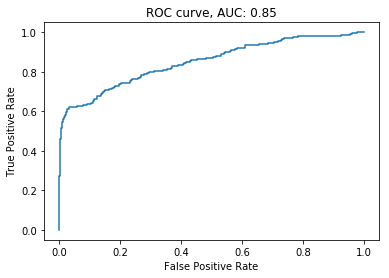

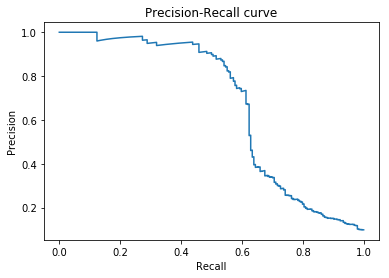

In [73]:
run_metrics(pred, pred_proba, yvalid, visualize=True)

## Use Tfidf for the features

In [74]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
count_train_idf = tfidf_vectorizer.fit_transform(xtrain)
count_valid_idf = tfidf_vectorizer.transform(xvalid)

In [75]:
nb_classifier.fit(count_train_idf, ytrain)
pred = nb_classifier.predict(count_valid_idf)
pred_proba = nb_classifier.predict_proba(count_valid_idf)[:,1]


Average precision-recall score: 0.16
[[1807    0]
 [ 181   13]]
Accuracy Score: 0.91


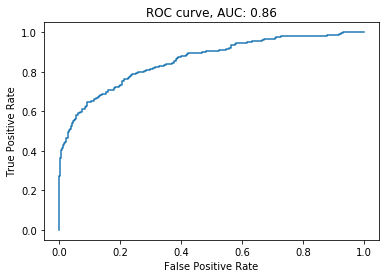

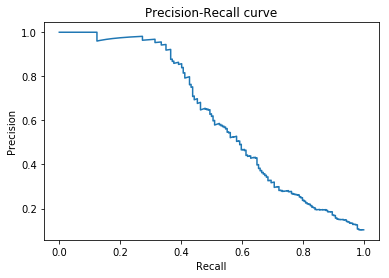

In [76]:
run_metrics(pred, pred_proba, yvalid, visualize=True)

## Use Deep Learning

In [77]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping, History, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam



## Preprocess data

### We will check the maximum number of words that can be present in a comment , this will help us in padding later

In [78]:
max_len = int(round(train['comment_text'].apply(lambda x:len(str(x).split())).max(), -2)+100)
print("Max length of comment text is: {}".format(max_len))

Max length of comment text is: 1500


### First do Tokenization of input corpus

In [79]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [80]:
word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'you': 5,
 'i': 6,
 'a': 7,
 'is': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'this': 13,
 'not': 14,
 'on': 15,
 'be': 16,
 'as': 17,
 'have': 18,
 'are': 19,
 'with': 20,
 'your': 21,
 'if': 22,
 'was': 23,
 'article': 24,
 'or': 25,
 'but': 26,
 'page': 27,
 'my': 28,
 'an': 29,
 'wikipedia': 30,
 'by': 31,
 'from': 32,
 'do': 33,
 'at': 34,
 'about': 35,
 'me': 36,
 'so': 37,
 'can': 38,
 'talk': 39,
 'what': 40,
 'there': 41,
 'has': 42,
 'all': 43,
 'no': 44,
 'will': 45,
 'one': 46,
 'would': 47,
 'like': 48,
 'please': 49,
 'he': 50,
 'just': 51,
 'they': 52,
 'any': 53,
 'been': 54,
 'which': 55,
 'his': 56,
 'more': 57,
 'other': 58,
 'we': 59,
 'here': 60,
 'should': 61,
 "don't": 62,
 'some': 63,
 'see': 64,
 'who': 65,
 'also': 66,
 'because': 67,
 'am': 68,
 'know': 69,
 'think': 70,
 "i'm": 71,
 'up': 72,
 'how': 73,
 'edit': 74,
 'why': 75,
 'out': 76,
 "it's": 77,
 'then': 78,
 'people': 79,
 'use': 80,
 'only': 81,
 'w

Example for fitting tokenizer line-by-line if corpus is too big to fit into memory

with open('/Users/liling.tan/test.txt') as fin: for line in fin:
t.fit_on_texts(line.split()) # Fitting the tokenizer line-by-line.

M = []

with open('/Users/liling.tan/test.txt') as fin: for line in fin:

    # Converting the lines into matrix, line-by-line.
    m = t.texts_to_matrix([line], mode='count')[0]
    M.append(m)

## Use pretrained word embeddings

## Convert our one-hot word index into semantic rich GloVe vectors

In [ ]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('jigsaw-multilingual-toxic-comment-classification/glove840b300dtxt/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
#Save embeddings so they can be easily loaded
#np.save('/kaggle/working/embedding_for_lstm_all', embedding_matrix)

In [81]:
#Load embeddings
embedding_matrix = np.load('jigsaw-multilingual-toxic-comment-classification/embedding_for_lstm_10K_sample.npy')

In [82]:
embedding_matrix.shape

(38848, 300)

## Simple RNN Model

In [32]:
opt = Adam(learning_rate=0.0001)

In [33]:
model1 = Sequential()
model1.add(Embedding(len(word_index) + 1,
                 300,
                 input_length=max_len))
model1.add(SimpleRNN(100))
model1.add(Dense(1, activation='relu'))
model1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
model1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1500, 300)         11654400  
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 100)               40100     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 11,694,601
Trainable params: 11,694,601
Non-trainable params: 0
_________________________________________________________________


In [34]:
model1.fit(xtrain_pad, ytrain, epochs=5, batch_size=100) #Multiplying by Strategy to run on TPU's

/Users/jkc/workspace/venv/vdata/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/5
8000/8000 [==============================] - 87s 11ms/step - loss: 0.5626 - accuracy: 0.8954
Epoch 2/5
8000/8000 [==============================] - 91s 11ms/step - loss: 0.3691 - accuracy: 0.9021
Epoch 3/5
8000/8000 [==============================] - 92s 12ms/step - loss: 0.2907 - accuracy: 0.9035
Epoch 4/5
8000/8000 [==============================] - 92s 12ms/step - loss: 0.2513 - accuracy: 0.9172
Epoch 5/5
8000/8000 [==============================] - 93s 12ms/step - loss: 0.2010 - accuracy: 0.9329


In [83]:
scores = model1.predict(xvalid_pad)[:, 0]
preds = scores>.5


Average precision-recall score: 0.16
[[1807    0]
 [ 181   13]]
Accuracy Score: 0.91


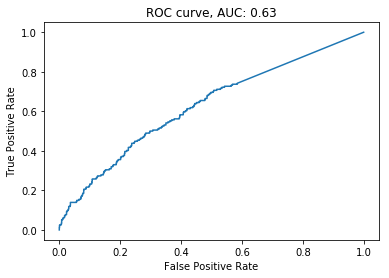

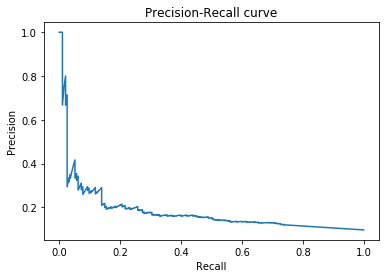

In [84]:
run_metrics(preds, scores, yvalid)

## Simple LSTM Model

In [85]:
%%time
# A simple LSTM with glove embeddings and one dense layer
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                 300,
                 weights=[embedding_matrix],
                 input_length=max_len,
                 trainable=False))

model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1500, 300)         11654400  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 11,814,901
Trainable params: 160,501
Non-trainable params: 11,654,400
_________________________________________________________________
CPU times: user 748 ms, sys: 254 ms, total: 1 s
Wall time: 293 ms


In [87]:
model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64)

/Users/jkc/workspace/venv/vdata/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/5
8000/8000 [==============================] - 222s 28ms/step - loss: 0.2360 - accuracy: 0.9149
Epoch 2/5
8000/8000 [==============================] - 197s 25ms/step - loss: 0.1601 - accuracy: 0.9419
Epoch 3/5
8000/8000 [==============================] - 186s 23ms/step - loss: 0.1528 - accuracy: 0.9471
Epoch 4/5
8000/8000 [==============================] - 193s 24ms/step - loss: 0.1417 - accuracy: 0.9471
Epoch 5/5
8000/8000 [==============================] - 191s 24ms/step - loss: 0.1296 - accuracy: 0.9539


In [88]:
scores = model.predict(xvalid_pad)
preds = scores>.5

Average precision-recall score: 0.16
[[1807    0]
 [ 181   13]]
Accuracy Score: 0.91


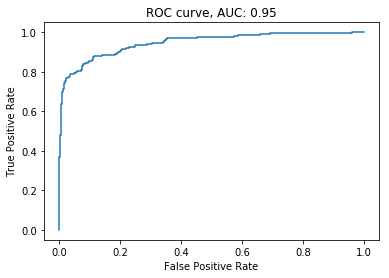

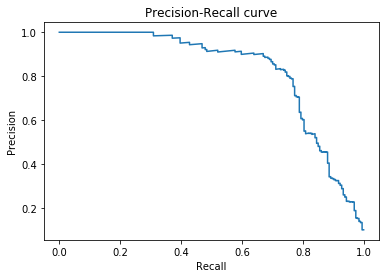

In [89]:
run_metrics(preds, scores, yvalid)

# Summary

So far, with very little preprocessing, we have achieved high accuracy. This is a little bit misleading however because the training set is highly imbalanced (roughly 10% positive/toxic class). 

Slightly older techniques, bag-of-words and tf-idf have done better than a simple deep learning models out-of-the-box. This can been seen by the higher AUCs and accuracy of these models in contrast to the simple RNN model. In addition, training these models was extremely fast, even on a local machine. In contrast, the deep learning models required more than 10 minutes to train even five epochs. In addition, trainingg the simple RNN required playing around with the learning rate to get network to learn. The first few attempts produced labels of all zeros. 

The simple LSTM model starts to improve dramatically over the simple RNN model even with only 5 epochs, showing that using the semantic rich word embeddings and including memory already improve simple deep learning results. Though the overall accuracy has decreased in the LSTM model vs the Naive Bayes models, the AUC and precision-recall and ROC curves are much better than the simple models. As we approach more state-of-the-art (SOTA) models, the results will likely improve even more dramatically.


## Try a GRU Model

In [ ]:
%%time
# GRU with glove embeddings and two dense layers
 model = Sequential()
 model.add(Embedding(len(word_index) + 1,
                 300,
                 weights=[embedding_matrix],
                 input_length=max_len,
                 trainable=False))
 model.add(SpatialDropout1D(0.3))
 model.add(GRU(300))
 model.add(Dense(1, activation='sigmoid'))

 model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model.summary()

In [ ]:
model.fit(xtrain_pad, ytrain, nb_epoch=5, batch_size=64*strategy.num_replicas_in_sync)

In [ ]:
scores = model.predict(xvalid_pad)


## Bidirectional RNN Model

In [ ]:
%%time
# A simple bidirectional LSTM with glove embeddings and one dense layer
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                 300,
                 weights=[embedding_matrix],
                 input_length=max_len,
                 trainable=False))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    
model.summary()

In [ ]:
model.fit(xtrain_pad, ytrain, nb_epoch=5, batch_size=64*strategy.num_replicas_in_sync)

In [ ]:
scores = model.predict(xvalid_pad)


## Seq2seq Architecture

In [ ]:
#TBD

## Transformers/Attention/BERT

In [ ]:
# Loading Dependencies
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers

from tokenizers import BertWordPieceTokenizer

Encoder FOr DATA for understanding waht encode batch does read documentation of hugging face tokenizer :
https://huggingface.co/transformers/main_classes/tokenizer.html here

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    Encoder for encoding the text into sequence of integers for BERT Input
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [ ]:
#IMP DATA FOR CONFIG

AUTO = tf.data.experimental.AUTOTUNE


# Configuration
EPOCHS = 3
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192

## Tokenization

For understanding please refer to hugging face documentation again

In [ ]:
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

In [ ]:
x_train = fast_encode(train1.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode(valid.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_test = fast_encode(test.content.astype(str), fast_tokenizer, maxlen=MAX_LEN)

y_train = train1.toxic.values
y_valid = valid.toxic.values

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [ ]:
def build_model(transformer, max_len=512):
    """
    function for training the BERT model
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

## Starting Training

If you want to use any another model just replace the model name in transformers._____ and use accordingly

In [ ]:
%%time
with strategy.scope():
    transformer_layer = (
        transformers.TFDistilBertModel
        .from_pretrained('distilbert-base-multilingual-cased')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

In [ ]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

In [ ]:
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=EPOCHS*2
)